# DOESN'T WORK AT CC-IN2P3 Injecting Synthetic Sources Into Single-Visit Images

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">
<br>
Contact author(s): Jeff Carlin <br>
Last verified to run: 2024-03-05 <br>
LSST Science Pipelines version: Weekly 2024_04 <br>
Container Size: medium <br>
Targeted learning level: advanced <br>

**Description:** This tutorial demonstrates a method to inject artificial sources (stars and galaxies) into calexp images using the measured point-spread function of the given calexp image. Confirmation that the synthetic sources were correctly injected into the image is done by running a difference imaging task from the pipelines. **DOESN'T WORK AT CC-IN2P3**

**Skills:** Use the `source_injection` tools to inject synthetic sources into images. Create a difference image from a `calexp` with injected sources.

**LSST Data Products:** Butler calexp images and corresponding src catalogs, goodSeeingDiff_templateExp images, and injection_catalogs.

**Packages:** astropy.io, astropy.coordinates, astropy.table, astropy.units, matplotlib, numpy, lsst.afw.display, lsst.afw.table, lsst.daf.base, lsst.daf.butler, lsst.ip.diffim, lsst.source.injection

**Credit:**
Developed by Jeff Carlin in collaboration with Lee Kelvin and the Rubin Community Science Team. Much of the material is based on the documentation for the LSST [source_injection package](https://pipelines.lsst.io/v/daily/modules/lsst.source.injection/index.html).

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>
and <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>.
Questions are welcome as new topics in the 
<a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> 
of the Rubin Community Forum. 
Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook provides a brief introduction to the `source_injection` package from the LSST Science Pipelines. The `source_injection` tools can be used to inject sources into images produced during various stages of Pipelines processing, including visit-level images (e.g., `calexp`s), any dataset with a `datasetType` of `Exposure` (e.g., `postISRCCD` images), and coadd images (e.g., `deepCoadd`s). The main driver that both creates and injects synthetic sources into images is based on [Galsim](https://galsim-developers.github.io/GalSim/), so that the `source_injection` tools enable injection of many types of sources. These include a variety of parameterized galaxy models, stars, and postage stamp images.

This notebook will teach some basics of using the `source_injection` package to insert artificial sources into images. Read the extensive [documentation](https://pipelines.lsst.io/v/daily/modules/lsst.source.injection/index.html) for more details and examples. Furthermore, the [Galsim](https://galsim-developers.github.io/GalSim/) documentation provides much more detail on the types of sources that can be injected.

### 1.1 Import packages

<a href="https://numpy.org">numpy</a> is a commonly used package for scientific computing with arrays in Python.

<a href="https://matplotlib.org/">matplotlib</a> is a library for creating static, animated, and
interactive visualizations in Python 
(see also the <a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>).

<a href="https://www.astropy.org/">astropy</a> is a package with many common astronomical utilities; here it is used for importing a FITS image, and working with coordinates and tables.

From the `lsst` package, modules for accessing the butler, image display functions, and the source injection utilities are imported (see <a href="https://pipelines.lsst.io/">pipelines.lsst.io</a> for documentation of the Science Pipelines codebase).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord

from lsst.afw.table import SourceTable
from lsst.daf.base import PropertyList
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import ConflictingDefinitionError
import lsst.afw.display as afwDisplay
from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig

afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

## 2. Get an image to inject sources into:

First, retrieve an image to inject sources into. To do so, instantiate a butler pointing to the DP0.2 dataset, identify `calexp` images overlapping a particular `tract`, and retrieve one of those images (plus some of its ancillary data) for later use.

### 2.1 Instantiate a butler

In [2]:
butler_config = '/sps/lsst/dataproducts/rubin/previews/dp0.2/'
collections = '2.2i/runs/FRDF/DP0.2/PREOPS-1145/step_all'
butler = Butler(butler_config, collections=collections)

### 2.2 Identify images overlapping a particular tract and select one

By default the next cell selects images from tract 3828, but you can change this to any tract number that exists in DP0.2 data. (See the map in Figure 15 of ["The DC2 Simulated Sky Survey"](https://ui.adsabs.harvard.edu/abs/2021ApJS..253...31L/abstract) overview paper; also visible in the [DP0.2 documentation](https://dp0-2.lsst.io/data-products-dp0-2/index.html#images)).

Because a `calexp` image only spans one detector, select a single detector (in this case, number 19, but change this if you like) and find images from the chosen tract that contain that detector.

In [3]:
tract = 3828
where = f"instrument='LSSTCam-imSim' AND skymap='DC2' AND \
          tract={tract} AND detector=19 AND band='g'"

calexp_g_DatasetRefs = sorted(list(set(butler.registry.queryDatasets('calexp', where=where))))

print(f'Identified {len(calexp_g_DatasetRefs)} calexp DatasetRefs')

# This uses the index "5" to select an arbitrary dataId.
# Change this index to select a different image.
dataId_g = calexp_g_DatasetRefs[5].dataId

print(f"{dataId_g = }")

Identified 23 calexp DatasetRefs
dataId_g = {instrument: 'LSSTCam-imSim', detector: 19, visit: 221616, band: 'g', physical_filter: 'g_sim_1.4', visit_system: 1}


#### 2.2.1 Retrieve the calexp image

In [4]:
calexp_g = butler.get('calexp', dataId=dataId_g)

#### 2.2.2 Retrieve additional information about the image

To generate synthetic sources to be injected into the image, you will need to know the coordinates of its bounding box. Retrieve the image's WCS and bounding box, and print its central coordinate to the screen:

In [5]:
wcs = calexp_g.getWcs()
bbox = calexp_g.getBBox()
print('bounding box: ', bbox)

boxcen = bbox.getCenter()
cen = wcs.pixelToSky(boxcen)
sc_cen = SkyCoord(ra=cen[0].asDegrees()*u.deg, dec=cen[1].asDegrees()*u.deg)

print(sc_cen)

bounding box:  (minimum=(0, 0), maximum=(4071, 3999))
<SkyCoord (ICRS): (ra, dec) in deg
    (56.5606462, -36.00526941)>


#### 2.2.3 Figure out how large the image is on the sky

Note that above the bounding box is roughly 4000 x 4000 pixels. Use the `bbox.getDimensions` and `wcs.getPixelScale` methods to estimate how large this image is in sky coordinates:

In [6]:
imsize = bbox.getDimensions()[0]*wcs.getPixelScale().asDegrees()
print('Size of calexp in degrees: ', imsize)

Size of calexp in degrees:  0.22584234361867267


## 3. Make and ingest a catalog of synthetic sources:

Having retrieved a `calexp` image to inject into, now set up a simple synthetic source catalog.

### 3.1 Make a catalog of galaxies and stars

The `source_injection` package provides tools to create catalogs of synthetic sources. Here, use the `generate_injection_catalog` function to create the sources to inject.

Note that the "inject_size" is selected to be 0.1 degrees, or slightly smaller than the size of the image as determined above (inject_size is a radius, so it equals 0.2/2 degrees).

In [7]:
inject_size = 0.2/2  # in degrees

#### 3.1.1 Make a catalog of galaxies to inject

The simplest form of a galaxy in Galsim is parameterized by a [Sersic model](https://en.wikipedia.org/wiki/S%C3%A9rsic_profile): $I(r) = I_e~{\rm exp}\{-b_n [(\frac{r}{r_e})^{1/n}-1]\}$, which defines the shape of the galaxy's light profile as a function of radius (r) in terms of the "Sersic index" (n) and the "half-light radius" ($r_e$). (Note that $n = 1$ corresponds to an exponential profile.)

The above equation results in a circular galaxy. To create elongated (elliptical) Sersic profiles, additionally specify the minor-to-major axis ratio (q) with a rotation angle (beta).

`generate_injection_catalog` will automatically generate sources with all possible permutations of the parameters you provide. For example, the cell below specifies "number=2" to create 2 synthetic galaxies, but then specifies a single magnitude (mag), 3 values of Sersic index (n), 3 values of axis ratio (q), 2 values of beta, and a single value for half_light_radius. This should result in $2*1*3*3*2*1 = 36$ different combinations of those parameters.

Finally, provide minimum and maximum RA and Dec coordinates in degrees. In this case, `generate_injection_catalog` will randomly select positions within those limits.

In [8]:
my_injection_catalog_galaxies = generate_injection_catalog(
    ra_lim=[sc_cen.ra.value-inject_size, sc_cen.ra.value+inject_size],
    dec_lim=[sc_cen.dec.value-inject_size, sc_cen.dec.value+inject_size],
    number=2,
    seed='3210',
    source_type="Sersic",
    mag=[15.0],
    n=[1, 2, 4],
    q=[0.9, 0.5, 0.1],
    beta=[31.0, 144.0],
    half_light_radius=[15.0],
)

#### 3.1.2 Make a catalog of stars to inject

Using a similar method, create a catalog of stars to be injected. Specify 5 values of magnitude, with 7 instances, which will result in 35 stars.

In [9]:
my_injection_catalog_stars = generate_injection_catalog(
    ra_lim=[sc_cen.ra.value-inject_size, sc_cen.ra.value+inject_size],
    dec_lim=[sc_cen.dec.value-inject_size, sc_cen.dec.value+inject_size],
    number=7,
    seed='432',
    source_type="Star",
    mag=[16.0, 17.0, 18.0, 19.0, 20.0],
)

#### 3.1.3 Combine the galaxies and stars into a single synthetic source catalog

In particular, use the [vstack](https://docs.astropy.org/en/stable/table/operations.html#id4) method from Astropy's [Table](https://docs.astropy.org/en/stable/table/index.html) class to combine them.

In [10]:
inject_cat = vstack([my_injection_catalog_galaxies, my_injection_catalog_stars])

In [11]:
inject_cat

injection_id,ra,dec,source_type,mag,n,q,beta,half_light_radius
int64,float64,float64,str6,float64,int64,float64,float64,float64
0,56.65093927532854,-36.03863528801498,Sersic,15.0,1,0.9,31.0,15.0
1,56.53218927532854,-35.915178497891525,Sersic,15.0,1,0.9,31.0,15.0
10,56.46968927532854,-35.942338991718685,Sersic,15.0,1,0.9,144.0,15.0
11,56.46343927532854,-36.09048713986683,Sersic,15.0,1,0.9,144.0,15.0
20,56.60718927532854,-36.04851183122486,Sersic,15.0,1,0.5,31.0,15.0
21,56.55093927532854,-36.02382047320017,Sersic,15.0,1,0.5,31.0,15.0
30,56.51343927532854,-35.93493158431128,Sersic,15.0,1,0.5,144.0,15.0
31,56.58218927532854,-35.93740072011374,Sersic,15.0,1,0.5,144.0,15.0
40,56.475939275328535,-35.994190843570536,Sersic,15.0,1,0.1,31.0,15.0


### 3.2 Add a postage stamp of an image to the injection catalog

In addition to parameterized sources of many types, a postage-stamp image (for example, an output image from a simulation) can also be injected. This can be any image; the only requirement is that it must be in FITS format and have a valid WCS (see a fun example [here](https://pipelines.lsst.io/v/d_2024_02_27/modules/lsst.source.injection/faqs.html#frequently-asked-questions-and-answers-about-synthetic-source-injection)). This notebook demonstrates injection of an [SDSS g-band image](https://ned.ipac.caltech.edu/byname?objname=NGC+4152&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1) of the galaxy PGC 038749 downloaded from the NASA/IPAC Extragalactic Database (NED).

Load the image, then display it to see what it depicts:

In [12]:
stamp_img_hdu = fits.open('data/PGC_038749_I_g_bbl2011.fits')

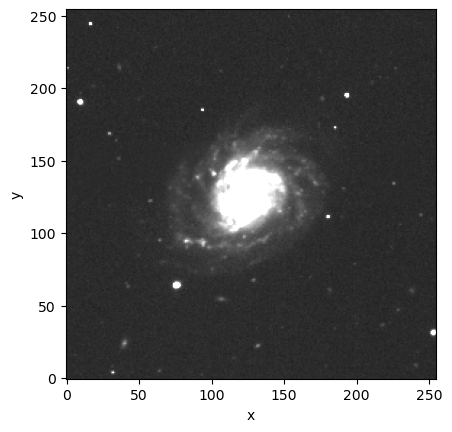

In [13]:
fig = plt.figure()
plt.subplot()
im = plt.imshow(stamp_img_hdu[0].data, cmap='gray', vmin=-20.0, vmax=100, origin='lower')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### 3.2.1 Create an entry in the injection catalog for the postage stamp image

Add a postage stamp entry into the injection catalog, using `vstack` to add an astropy `Table` containing a single row. You must specify its position, magnitude, and "source_type = Stamp," in addition to the filename of the image to inject. (It is OK to leave unnecessary columns empty.)

In [14]:
my_injection_catalog_stamp = Table(
    {
        'injection_id': [9999],
        'ra': [56.622],
        'dec': [-36.488],
        'source_type': ['Stamp'],
        'mag': [14.8],
        'stamp': ['PGC_038749_I_g_bbl2011.fits'],
        'stamp_prefix': ['data/'],
    }
)

In [15]:
inject_cat = vstack([inject_cat, my_injection_catalog_stamp])

In [16]:
inject_cat

injection_id,ra,dec,source_type,mag,n,q,beta,half_light_radius,stamp,stamp_prefix
int64,float64,float64,str6,float64,int64,float64,float64,float64,str27,str5
0,56.65093927532854,-36.03863528801498,Sersic,15.0,1,0.9,31.0,15.0,--,--
1,56.53218927532854,-35.915178497891525,Sersic,15.0,1,0.9,31.0,15.0,--,--
10,56.46968927532854,-35.942338991718685,Sersic,15.0,1,0.9,144.0,15.0,--,--
11,56.46343927532854,-36.09048713986683,Sersic,15.0,1,0.9,144.0,15.0,--,--
20,56.60718927532854,-36.04851183122486,Sersic,15.0,1,0.5,31.0,15.0,--,--
21,56.55093927532854,-36.02382047320017,Sersic,15.0,1,0.5,31.0,15.0,--,--
30,56.51343927532854,-35.93493158431128,Sersic,15.0,1,0.5,144.0,15.0,--,--
31,56.58218927532854,-35.93740072011374,Sersic,15.0,1,0.5,144.0,15.0,--,--
40,56.475939275328535,-35.994190843570536,Sersic,15.0,1,0.1,31.0,15.0,--,--


### 3.3 Ingest the synthetic source catalog into a butler collection

#### 3.3.1 Register the source injection collection
The input `inject_cat` will be ingested into a collection called `u/{user}/test_injection_inputs` (where "user" will be your username) in the butler repository. You must register this collection for subsequent use.

First, instantiate a writeable `butler`. Butlers are instantiated in read-only mode by default. By setting the argument `writeable` to `True`, a butler can also be made to be writeable.

> Warning: take care when working with a writeable butler, as data on-disk has the potential to be permanently removed or corrupted.

_Note: If you attempt to inject synthetic sources into a collection that already exists, the task will complain that the output data already exist on disk. The name you assign to your collection in `INJECTION_CATALOG_COLLECTION` in the following cell must not have been used before. (This means that if you have run source injection already, you must change the output collection name before running again.)_

In [17]:
# Get username.
user = os.getenv("USER")

INJECTION_CATALOG_COLLECTION = f"u/{user}/test_injection_inputs"

# Instantiate a writeable butler.
writeable_butler = Butler(butler_config, writeable=True)

ProgrammingError: (psycopg2.errors.InsufficientPrivilege) permission denied for table opaque_meta

[SQL: INSERT INTO dp02.opaque_meta (table_name) VALUES (%(table_name)s) ON CONFLICT DO NOTHING]
[parameters: {'table_name': 'file_datastore_records'}]
(Background on this error at: https://sqlalche.me/e/20/f405)

Now ingest the catalog of synthetic sources into the butler collection using the `ingest_injection_catalog` function:

In [ ]:
try:
    my_injected_datasetRefs = ingest_injection_catalog(
        writeable_butler=writeable_butler,
        table=inject_cat,
        band="g",
        output_collection=INJECTION_CATALOG_COLLECTION,
    )
except ConflictingDefinitionError:
    print(f"Found an existing collection named INJECTION_CATALOG_COLLECTION={INJECTION_CATALOG_COLLECTION}.")
    print("\nNOTE THAT IF YOU SEE THIS MESSAGE, YOUR CATALOG WAS NOT INGESTED."\
          "\nYou may either continue with the pre-existing catalog, or choose a new"\
          " name and re-run the previous cell and this one to ingest a new catalog.")

## 4. Inject sources into a calexp image

### 4.1 Use source_injection tools to inject sources

The catalog specifying synthetic sources has been ingested into the butler. Now run the task from `source_injection` that injects sources into the `calexp` image that was retrieved earlier.

First, extract the point spread function (PSF), photometric calibration object, and the WCS (World Coordinate System) object associated with the `calexp` image. These will be passed to the injection task so that sources can be injected using the properties of the image itself.

In [ ]:
psf = calexp_g.getPsf()
photo_calib = calexp_g.getPhotoCalib()
wcs = calexp_g.getWcs()

Load the input injection catalogs that were ingested into the butler in the previous step.

In [ ]:
# Load input injection catalogs.
injection_refs = butler.registry.queryDatasets(
    "injection_catalog",
    band="g",
    collections=INJECTION_CATALOG_COLLECTION,
)
injection_catalogs = [
    butler.get(injection_ref) for injection_ref in injection_refs
]

### 4.2 Instantiate the injection classes

First, instantiate the `VisitInjectConfig` class. The `VisitInjectConfig` class is where configuration of the injection task occurs, allowing for modifications to be made to how the task operates. Here, change the "stamp_prefix" configuration option to "data/" so that `source_injection` knows to look for the image in the `data/` folder.

Then instantiate the `VisitInjectTask`, using `inject_config` as the configuration argument.

NOTE: For injections into other dataset types, use the appropriate option from the following list:
```
from lsst.source.injection import CoaddInjectConfig, CoaddInjectTask
from lsst.source.injection import ExposureInjectConfig, ExposureInjectTask
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
```
Both `ExposureInject` and `VisitInject` accept dimensions of `("instrument", "visit", "detector")`. They differ in that `ExposureInject` takes a `postISRCCD` exposure (i.e., a raw image that has had "instrument signature removal," or ISR, applied, and no further processing) as an input, while `VisitInject` expects to operate on a `calexp` (an image that has been astrometrically and photometrically calibrated to an external source).

In [ ]:
inject_config = VisitInjectConfig()
inject_config.stamp_prefix='data/'

inject_task = VisitInjectTask(config=inject_config)

### 4.3 Inject sources into an image

Next, execute the `run` method of the `inject_task`.

The `run` method needs the following inputs:

* the input injection catalog
* the input `calexp`
* the PSF of the input exposure
* the WCS information
* the photometric calibration information

The PSF, WCS, and photo_calib inputs were already retrieved directly from the `calexp` they are associated with.

The inject task provides two outputs:

* the output exposure with sources injected
* the output source injection catalog

The output source injection catalog is identical to the input, but with two additional columns (x and y) denoting the pixel coordinates of these sources. Note that this catalog is NOT the science catalog containing the full suite of LSST Science Pipelines outputs. To get that, this source injected image will need to be processed by additional Science Pipelines tasks.

> Note: it is best to use a clone of the input `calexp`. This is because the `calexp` that is input for source injection will be edited in-place. Inputting a clone makes it possible to compare the output image to the original `calexp` later in this notebook.

#### 4.3.1 Run the source injection task
Run the source injection task and extract the "output_exposure" and "output_catalog":

In [ ]:
injected_output = inject_task.run(
    injection_catalogs=injection_catalogs,
    input_exposure=calexp_g.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure = injected_output.output_exposure
injected_catalog = injected_output.output_catalog

#### 4.3.2 Compare the images before and after injection

Plot the images side-by-side to confirm that the source injection task successfully added sources to the image.

Note that the injected image will have different flux values than the original, which would cause the image scaling of the two images to be slightly different by default (to confirm this, uncomment the "display0.scale('linear', 'zscale')" lines below and comment out the lines below them that explicitly set the min/max values). For a direct comparison, explicitly set the minimum and maximum pixel values of the color scale.

Additionally, to zoom in on the injected postage stamp to see how it looks in the image, uncomment the line below where it says "To zoom on the PGC 038749 stamp:".

In [ ]:
plot_injected_calexp = injected_exposure.clone()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
# display0.scale('linear', 'zscale')
display0.scale('linear', min=-20, max=150)
display0.mtv(calexp_g.image)
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
# display1.scale('linear', 'zscale')
display1.scale('linear', min=-20, max=150)
display1.mtv(plot_injected_calexp.image)
# To zoom on the PGC 038749 stamp:
# display1.mtv(plot_injected_calexp.image[3300:3800, 1500:2000])
plt.title('injected_calexp image')

plt.tight_layout()
plt.show()

### 4.4 Create a difference image to see the injected sources

One reason for injecting sources into a `calexp` image might be to test whether they would be recovered in a difference image. This section demonstrates the use of an image differencing task from the LSST Science Pipelines to create a difference image.

#### 4.4.1 Load the template image
Template images are created as coadds of the images with the best seeing, and are called `goodSeeingDiff_templateExp`. Load the appropriate template corresponding to the `calexp` used throughout this notebook (note the use of the same dataId used to load the `calexp`).

In [ ]:
difftemp = 'goodSeeingDiff_templateExp'
templateExposure = butler.get(difftemp, dataId=dataId_g.required)

#### 4.4.2 Initialize and run the image subtraction task

The first two lines below load the default configuration for the `AlardLuptonSubtract` task, and then initialize the task with that configuration. The task requires (1) a template exposure, (2) the science exposure, and (3) the catalog of sources from the science exposure.

Load the source catalog (`src`) and run the task:

In [ ]:
config = AlardLuptonSubtractConfig()
alTask = AlardLuptonSubtractTask(config=config)

scienceExposure = injected_exposure

sources = butler.get('src', dataId=dataId_g)
result = alTask.run(templateExposure, scienceExposure, sources)

#### 4.4.3 Compare the original and the difference image

Plot the original `calexp`, the injected image, and the difference image side by side:

In [ ]:
# Zoom in on an arbitrary section of the image.
# Change these coordinates to see a different region.
xmin, xmax = 500, 2000
ymin, ymax = 1000, 2500

fig, ax = plt.subplots(1, 3, figsize=(14, 11))
plt.sca(ax[0])  # set the first axis as current
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(calexp_g.image)
plt.title('coadd image (template)')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.sca(ax[1])  # set the second axis as current
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
display2.mtv(plot_injected_calexp.image)
plt.title('calexp with synthetic sources')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.sca(ax[2])  # set the third axis as current
display3 = afwDisplay.Display(frame=fig)
display3.scale('linear', 'zscale')
display3.mtv(result.difference.image)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title('diffim')
plt.tight_layout()
plt.show()

# 6. Exercises for the learner

Further explorations could include:

1.  Injecting sources into coadd images.
2.  Exploring other types of objects that can be injected into images (i.e., other Galsim parameters for more complicated sources).
3.  Injecting variable objects into multiple calexp images and testing their recoverability.
4.  Running detection and measurement tasks from the LSST Science Pipelines to test the recovery and measurement accuracy of injected sources (e.g., following DP0.2 tutorial [Notebook 05: Introduction to Source Detection](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP02_05_Introduction_to_Source_Detection.ipynb)).